# Biblioteki Pythona w analizie danych
### Tomasz Rodak

Lab 10

---



## 10 Transfer learning

Celem tego laboratorium jest zapoznanie się z metodą [*transfer learningu*](https://en.wikipedia.org/wiki/Transfer_learning) (uczenia transferowego). Transfer learning to technika uczenia maszynowego, która polega na przenoszeniu wiedzy zdobytej podczas rozwiązywania jednego problemu do innego, pokrewnego problemu. W praktyce oznacza to, że zamiast trenować model od podstaw na dużym zbiorze danych, możemy wykorzystać model, który został już wytrenowany na innym zbiorze danych i dostosować go do naszych potrzeb. Jest to szczególnie przydatne w sytuacjach, gdy mamy ograniczone zasoby obliczeniowe lub mało danych do trenowania.

Transfer learning zademonstrujemy na przykładzie problemu rozpoznawania obrazów. Wykorzystamy do tego celu pretrenowany model [ResNet18](https://arxiv.org/pdf/1512.03385). Obrazy do klasyfikacji pobierzemy z sekcji *Images* wyszukiwarki [DuckDuckGo](https://duckduckgo.com/). Wykorzystamy PyTorch do budowy i trenowania modelu.

Arkusz ten powstał na podstawie kursu [fastai](https://course.fast.ai/), Getting Started

### 10.1 Instalacje i importy

Brakuje nam pakietu [`duckduckgo-search`](https://github.com/deedy5/duckduckgo_search). Pakiet ten wykorzystamy do utworzenia listy odnośników do obrazów, zainstalujesz go poleceniem:

In [1]:
!pip install duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.2 MB/s eta 0:00:00


In [2]:
import asyncio
import hashlib
import os
from io import BytesIO
from pathlib import Path

import httpx
import requests
import tqdm.notebook as tqdm
from duckduckgo_search import DDGS
from PIL import Image, UnidentifiedImageError

### 10.2 Pobieranie obrazów

Dla uproszczenia załóżmy, że chcemy rozpoznać dwa rodzaje obrazów, później możesz to oczywiście zmienić. Zaproponuj jakieś dwie kategorie. Dane będziemy pobierać z wyszukiwarki DuckDuckGo z sekcji *Images* wyszukiwania, więc uwzględnij wynikające stąd ograniczenia. Wybór bardzo specyficznej kategorii o słabej reprezentacji w internecie może skutkować nieadekwatnym zbiorem danych. Wybierz takie kategorie, o których spodziewasz się, że będą miały dobrą reprezentację w internecie.

#### 10.2.1 Funkcje pomocnicze

Funkcje `to_hash()` i `seen_files()` są pomocnicze. Funkcja `to_hash()` konwertuje ciąg znaków na hash MD5, a funkcja `seen_files()` pobiera zbiór nazw plików (bez rozszerzeń) z folderu. Użyjemy ich do sprawdzenia, czy dany obraz został już pobrany. Takie śledzenie plików jest istotne, gdyż różne zapytania do wyszukiwarki mogą czasami zwracać te same obrazy - nie chcemy ich pobierać więcej niż raz.

In [6]:
def to_hash(s):
    """
    Konwertuje ciąg znaków na hash MD5.

    Argumenty:
        s (str): Ciąg znaków do hashowania

    Zwraca:
        str: Hash MD5 podanego ciągu w formacie szesnastkowym
    """
    return hashlib.md5(s.encode()).hexdigest()

def seen_files(folder):
    """
    Pobiera zbiór nazw plików (bez rozszerzeń) z folderu.

    Argumenty:
        folder (str lub Path): Ścieżka do folderu do przeskanowania

    Zwraca:
        set: Zbiór nazw plików bez rozszerzeń
    """
    files = os.listdir(folder)
    return set(Path(file).stem for file in files)

#### 10.2.2 Foldery

Tworzę folder `datasets/imgrec`, w którym będą przechowywane pobrane obrazy. Będę rozpoznawał obrazy dzika i jelenia. Aby je przechować, tworzę podfoldery `boar` i `deer`. Powinieneś wybrać inne kategorie, ale foldery powinny mieć podobną strukturę. Oznacza to, że powinieneś również dokonać odpowiednich zmian w kodzie poniżej, tak aby odpowiadał Twoim kategoriom.

In [3]:
!mkdir -p datasets/imgrec
!mkdir -p datasets/imgrec/asian
!mkdir -p datasets/imgrec/black

#### 10.2.3 Zapytanie do wyszukiwarki

W tym miejscu tworzymy zapytanie do wyszukiwarki. **Upewnij się, że zapytanie jest odpowiednie do kategorii!** (zmienne `keywords` i `category`). Zbiór danych zostałby uszkodzony, gdybym przykładowo w kategorii `boar` dodał zapytanie o `deer`. W takim przypadku nie da się poprawnie wytrenować modelu.

Zapytanie delegowane jest do wyszukiwarki DuckDuckGo, która zwraca listę linków do obrazów (`images_links`).

In [35]:
from duckduckgo_search import DDGS

keywords = 'asian people photo'
category = 'asian'

with DDGS() as ddgs:
    images_gen = ddgs.images(
        keywords,
        max_results=100
    )
    images_links = list(images_gen)

#### 10.2.4 Pobieranie obrazów

Główna pętla pobierająca obrazy iteruje po wszystkich linkach i pobiera je asynchronicznie. Używamy `asyncio` do równoległego pobierania obrazów, co przyspiesza cały proces. Ważne zmienne:
- `FOLDER` - folder, w którym znajduje się zbiór danych
- `subfolder` - podfolder, w którym będą przechowywane pobrane obrazy w danej kategorii
- `already_seen` - zbiór nazw plików, które zostały już pobrane.

Nazwy plików są generowane na podstawie hasha MD5 adresu URL obrazu. Dzięki temu unikamy niespodziewanych znaków w nazwach plików. Funkcja `download_image_async()` sprawdza liczne możliwe błędy:
- `httpx.HTTPError` - błąd HTTP
- `httpx.TimeoutException` - przekroczony czas oczekiwania na odpowiedź
- `UnidentifiedImageError` - błąd związany z otwieraniem obrazu, dzięki czemu zapisujemy tylko poprawne obrazy.

Program ten możesz wykonywać wielokrotnie, pamiętaj jednak, aby wcześniej wstawić odpowiednie zapytanie i kategorię w komórce powyżej.

In [36]:
FOLDER = Path('datasets/imgrec')
subfolder = FOLDER/category
already_seen = seen_files(subfolder)
print(f'Now {len(already_seen)} files in {subfolder}')
counter = 0

async def download_image_async(client, image_url, already_seen, subfolder, to_hash, semaphore):
    async with semaphore:  # Limit concurrent downloads
        file = to_hash(image_url)

        if file in already_seen:
            print(f'Already seen: {file}={image_url}')
            return None

        try:
            headers = {
                'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:120.0) Gecko/20100101 Firefox/120.0'
            }
            r = await client.get(image_url, headers=headers, timeout=5)
        except httpx.HTTPError as e:
            print(f'HTTPError: {e} for {image_url}')
            return None
        except httpx.TimeoutException:
            print(f'Timeout: {image_url}')
            return None
        except httpx.SSLError:
            print(f'SSLError: {image_url}')
            return None

        try:
            img = Image.open(BytesIO(r.content))
        except UnidentifiedImageError:
            print(f'Image error for {image_url}')
            return None

        file = Path(file).with_suffix(f'.{img.format.lower()}')
        print(f'New file = {image_url}')

        with open(subfolder/file, 'wb') as f:
            f.write(r.content)
            print(f'Saved {file} to {subfolder}')

        return file

max_concurrent = 10
semaphore = asyncio.Semaphore(max_concurrent)

client = httpx.AsyncClient(limits=httpx.Limits(max_connections=20))

tasks = []
for image in images_links:
    image_url = image['image']
    task = download_image_async(client, image_url, already_seen, subfolder, to_hash, semaphore)
    tasks.append(task)

results = await asyncio.gather(*tasks)
await client.aclose()  # Close the client when done

successful = [r for r in results if r is not None]
print(f'Total files downloaded: {len(successful)}')

Now 250 files in datasets/imgrec/asian
Already seen: 050a09c4a761ea02696163a99e3d9f98=https://media.gettyimages.com/id/543073340/photo/multi-ethnic-asian-people-portraits.jpg?s=1024x1024&w=gi&k=20&c=QgnjJfPidvqWXsN-vb_z05RXr-3p8-oH-DJwLttTykk=
Already seen: 364906fcbfc254fed839aa1b271d2056=https://get.pxhere.com/photo/man-person-people-male-asian-portrait-young-chinese-professional-business-profession-hairstyle-confident-spokesperson-businessperson-white-collar-worker-922334.jpg
Already seen: ec21c31dd8c569637d5e653eb4721f4b=https://thumbs.dreamstime.com/z/asian-people-happy-women-wearing-national-traditional-clothing-beautiful-smiling-girls-friends-ao-dai-dresses-vietnamese-costume-67464844.jpg
Already seen: 5cd5cff64049ddcd9728090d2da4fda4=https://www.goodfreephotos.com/albums/people/cute-asian-girl-smiling-and-looking-up.jpg
Already seen: 6fb8f3e429f114e7441347c73dcd1581=https://cdn7.dissolve.com/p/D145_165_545/D145_165_545_1200.jpg
Already seen: 494646dba4f93f63d3375b28be933f3a=htt

#### 10.2.5 Rozmiar zebranych danych

Rozmiar folderu `datasets/imgrec`:

In [37]:
!du -hsc datasets/imgrec

177M	datasets/imgrec
177M	total


Liczba pobranych obrazów w folderze `boar`:

In [38]:
!ls -lh datasets/imgrec/asian/|wc -l

255


Liczba pobranych obrazów w folderze `deer`:

In [39]:
!ls -lh datasets/imgrec/black/|wc -l

271


### 10.3 Klasyfikacja
#### 10.3.1 Przygotowanie danych treningowych

Wykorzystamy zbiór danych, który pobraliśmy w poprzednim kroku. Musimy przygotować go do treningu naszego modelu, co obejmuje:
1. Załadowanie obrazów z dysków
2. Podzielenie na zbiór treningowy, walidacyjny i testowy
3. Przekształcenie ich do odpowiedniego formatu, zastosowanie augmentacji i normalizacji


Załaduj zbiór danych z dysku. Wykorzystaj `torchvision.datasets.ImageFolder` z parametrem `transform=None`.
Zobacz, jakiego rodzaju obiekt otrzymałeś. Podejrzyj jego atrybuty. Wyświetl przykładowe obrazki.

In [41]:
from torchvision import datasets

full_dataset = datasets.ImageFolder(FOLDER, transform=None)

In [42]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 524
    Root location: datasets/imgrec

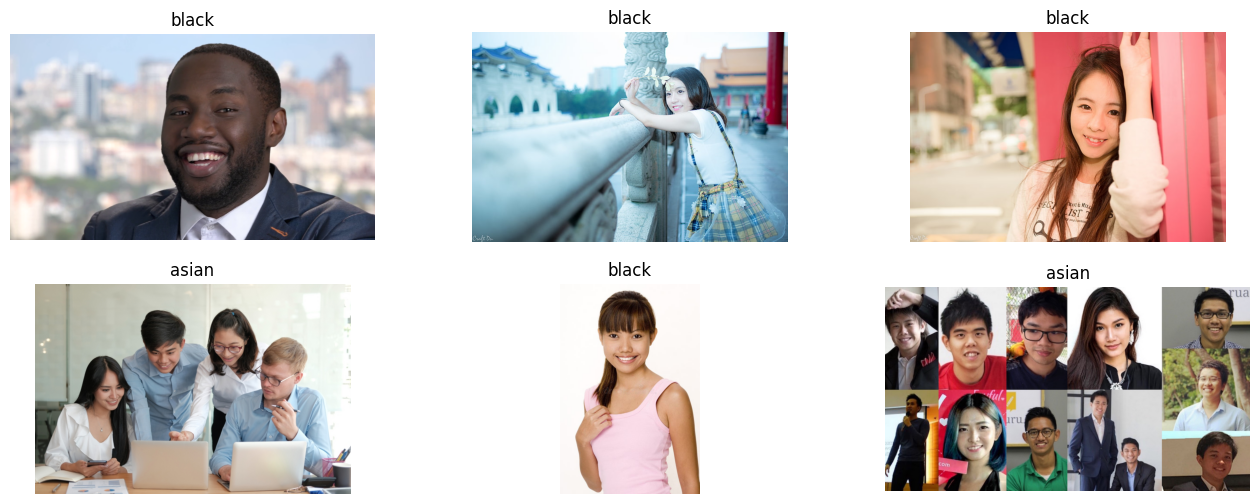

In [76]:
# prompt: wyswietl jedno z zdjec z full_dataset
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

fig,axs = plt.subplots(2,3, figsize=(16,6))
for ax in axs.flatten():
  random_idx = random.choice(range(len(full_dataset)))
  img, label = full_dataset[random_idx]
  ax.imshow(img)
  ax.set_title(full_dataset.classes[label])
  ax.axis('off')
plt.show()

Podziel zbiór na treningowy, walidacyjny i testowy. Użyj `torch.utils.data.random_split()`. Ustaw generator, aby zapewnić powtarzalność podziału: `generator=torch.Generator().manual_seed(<seed>)`. W wyniku tej operacji otrzymasz trzy zbiory danych typu `torch.utils.data.dataset.Subset` - są to **widoki** na fragmenty oryginalnego zbioru danych.

In [77]:
from torch.utils.data import random_split
import torch
train_ds, val_ds, test_ds = random_split(full_dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [79]:
[a for a in dir(train_ds) if not a.startswith("_")]

['dataset', 'indices']

Oblicz proporcje klas w zbiorze treningowym, walidacyjnym i testowym. Możesz użyć np. `collections.Counter`.

In [82]:
from collections import Counter
print("proporcje w zbiortze treningowym")
ct = Counter([full_dataset.classes[full_dataset.targets[i]] for i in train_ds.indices])
for k,v in ct.items():
  print(f"{k}: {v/len(train_ds):.2%}")
print("\nProporcje w zbiorze testowym")
ct = Counter([full_dataset.classes[full_dataset.targets[i]] for i in val_ds.indices])
for k,v in ct.items():
  print(f"{k}: {v/len(test_ds):.2%}")
print("\nProporcje w zbiorze walidacyjnym")
ct = Counter([full_dataset.classes[full_dataset.targets[i]] for i in test_ds.indices])
for k,v in ct.items():
  print(f"{k}: {v/len(val_ds):.2%}")

proporcje w zbiortze treningowym
black: 52.59%
asian: 47.41%

Proporcje w zbiorze testowym
asian: 52.56%
black: 48.72%

Proporcje w zbiorze walidacyjnym
black: 49.37%
asian: 49.37%


Zdefiniuj transformacje:
- dla zbioru treningowego:
  - losowa zmiana rozmiaru i przycięcie do 224x224
  - losowe odbicie lustrzane
  - konwersja do tensora
  - normalizacja (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
- dla zbioru walidacyjnego i testowego:
  - zmiana rozmiaru do 256
  - przycięcie do 224x224
  - konwersja do tensora
  - normalizacja (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`, dane z ImageNet)

Do obrazów chcemy stosować różne transformacje – osobne dla zbioru treningowego, walidacyjnego i testowego. W instancjach klas dziedziczących po `torch.utils.data.Dataset` (np. `ImageFolder`) transformacje, jeśli zostały przekazane jako argument `transform`, są wywoływane automatycznie w metodzie `__getitem__()`.

Ponieważ chcemy zachować jeden wspólny zestaw danych (np. z `ImageFolder`), a podziały na train/val/test mają korzystać z różnych transformacji, stworzymy własny wrapper. Napisz klasę `TransformedSubset`, dziedziczącą po `torch.utils.data.Dataset`, która:
1. W konstruktorze przyjmuje:
   * dowolny obiekt `torch.utils.data.Dataset` lub `Subset` (np. wynik `random_split`),
   * obiekt transformacji (`torchvision.transforms.Compose` albo inny).
2. Nadpisuje metodę `__getitem__(self, idx)`, aby:
   * pobrać surowy przykład przez `self.subset[idx]`,
   * nałożyć przekazaną transformację na obraz,
   * zwrócić `(image_transformed, label)`.
3. Nadpisuje metodę `__len__(self)`, delegując wywołanie do wewnętrznego podzbioru (`len(self.subset)`).

Zastosuj `TransformedSubset` do każdego podzbioru. Użyj `torch.utils.data.DataLoader`, aby utworzyć iteratory dla każdego zbioru danych. Ustaw odpowiedni rozmiar wsadu i `shuffle=True` dla zbioru treningowego oraz `shuffle=False` dla pozostałych zbiorów.

#### 10.3.2 Model

Pobierz (pretrenowany) model ResNet18 z repozytorium torchvision. Ustaw go w tryb ewaluacji. Sprawdź, czy GPU jest dostępne. Jeśli tak, przenieś tam model.

#### 10.3.2 Modyfikacja modelu

Modyfikujemy model ResNet18, aby dostosować go do naszego zadania klasyfikacji: ostatnią warstwę, zmieniamy tak aby miała 2 wyjścia (boar i deer) zamiast 1000 (jak w oryginalnym modelu trenowanym na ImageNet). Jedynie ta warstwa będzie trenowana, pozostałe będą zamrożone.

Ustaw `requires_grad=False` dla wszystkich parametrów modelu. Skutek tego działania jest taki, że podczas trenowania modelu nie będą one aktualizowane.


Zidentyfikuj ostatnią warstwę modelu i podmień ją na `nn.Linear(<in_features>, 2)`, gdzie `<in_features>` to liczba cech wejściowych tej warstwy.

#### 10.3.3 Trenowanie modelu

Ustaw funkcję straty.

Ustaw optymalizator:

Przeprowadź trening modelu. W miarę możliwości śledź postęp treningu. Ile epok należy przeprowadzić?

#### 10.3.4 Ocena

- Oblicz dokładność i wyświetl macierz pomyłek dla zbioru testowego.
- Pokaż przykłady błędnie sklasyfikowanych obrazów.
- Wykonaj klasyfikacje dla nowych obrazów pobranych z internetu.